# 1. Environment Setup

## 1.1. Mount Google Drive

We begin by mounting your Google Drive to the Colab environment. This step is essential as it allows the notebook to access files you have stored there, such as the pre-processed dataset. We will first import the necessary library from `google.colab`.

In [1]:
# --- 1.1 Mount Google Drive to access your data ---
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Mounted at /content/drive
Google Drive mounted successfully.


## 1.2. Install Core Libraries

Next, we install the Python libraries required for fine-tuning. We use `pip` with the `-Uq` flags to upgrade (`-U`) the packages to their latest versions quietly (`-q`).

*   **`transformers`**: The primary library from Hugging Face. It provides the pre-trained models (like `Phi-4-mini`), tokenizers, and the `TrainingArguments` class we will use to configure the training loop.
*   **`peft`**: Stands for Parameter-Efficient Fine-Tuning. This library enables us to use techniques like LoRA and QLoRA, which drastically reduce the memory and computational cost of fine-tuning by only training a small number of new parameters (adapters) instead of the entire model.
*   **`trl`**: The Transformer Reinforcement Learning library, which also contains the high-level `SFTTrainer`. This trainer is specifically designed for Supervised Fine-Tuning and simplifies the process by handling data formatting and the training loop for us.
*   **`accelerate`**: A utility from Hugging Face that `SFTTrainer` uses under the hood to handle device management (e.g., automatically placing tensors on the GPU) and optimize training.
*   **`datasets`**: Used for efficiently loading and processing our data, which is stored in Hugging Face's `DatasetDict` format.
*   **`bitsandbytes`**: The key library that enables 4-bit quantization. It allows us to load the large base model in a compressed format, which is the foundation of the QLoRA method.
*   **`flash-attn`**: An essential library for optimization. It provides an implementation of FlashAttention, a highly efficient algorithm for the attention mechanism in transformers that reduces memory usage and significantly speeds up training on compatible GPUs (like the A100).

In [19]:
# --- 1.2. Install Core Libraries (Revised for Compatibility) ---

# Install the other libraries as before
!pip install -Uq transformers
!pip install -Uq peft
!pip install -Uq trl
!pip install -Uq accelerate
!pip install -Uq datasets
!pip install -Uq bitsandbytes

!pip uninstall -y flash-attn flash_attn-2_cuda  # clean slate (optional)

# Now, reinstall flash-attn, forcing it to compile against our environment's torch version
!pip install flash-attn==2.5.6 --no-build-isolation \
       --extra-index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 26.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user

## 1.3. Unzip Dataset

With the libraries installed, we now need to make our dataset accessible in the Colab environment. The dataset is currently in a zipped archive (`level-1-binary.zip`) in Google Drive. This command uses the `unzip` utility to extract the contents of the archive into the `/content/` directory of the Colab virtual machine. This is a one-time setup step for our session.

In [20]:
# --- 1.3 Unzip Dataset ---
# This assumes the zip file is in the "My Drive" folder
!unzip -q /content/drive/My\ Drive/level-1-binary.zip -d /content/
print("Dataset unzipped to '/content/level-1-binary'.")

replace /content/__MACOSX/._level-1-binary? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset unzipped to '/content/level-1-binary'.


# 2. Configuration

## 2.1. Define Basic Project Parameters

We will start by defining a simple configuration class, `BasicConfig`, to hold the most fundamental parameters of our project that are unlikely to change between experiments. This includes the model identifier and the paths for our data and outputs. This keeps our code clean and organized.

In [21]:
# --- 2.1 Define Basic Project Parameters ---
class BasicConfig:
    # The Hugging Face Hub identifier for the model we are fine-tuning.
    MODEL_ID = "microsoft/Phi-4-mini-instruct"

    # The local path to the unzipped dataset we prepared earlier.
    DATASET_PATH = "/content/level-1-binary"

    # The directory where all outputs (checkpoints, logs) will be saved.
    OUTPUT_DIR = "/content/solution-verifier-level1"

## 2.2. Define the SFT Configuration

This is the central configuration step for our training process. We will use `SFTConfig`, a specialized class from the `trl` library, which inherits from `TrainingArguments` but adds crucial features for Supervised Fine-Tuning. This integrated approach is more robust and cleaner than setting arguments manually.

### Core Training Hyperparameters
-   **`output_dir`**: Specifies the directory where all training artifacts (model checkpoints, logs, adapter weights) will be saved.
-   **`num_train_epochs`**: The total number of times the trainer will iterate over the entire training dataset. A value of `3` is a standard starting point for fine-tuning, often providing a good balance between learning the task and avoiding overfitting.
-   **`learning_rate`**: The step size for the optimizer. This determines how large of a change is made to the adapter weights at each optimization step. A rate of `2e-4` is a common and effective choice for fine-tuning with the AdamW optimizer.

### Batching and Memory Strategy
-   **`per_device_train_batch_size`**: The number of training samples processed on a single GPU in one forward/backward pass. This is a critical hyperparameter limited by VRAM. We set it to `8`.
-   **`gradient_accumulation_steps`**: A memory-saving technique where gradients from several smaller batches are accumulated before performing a model weight update. This allows us to simulate a much larger "effective batch size" (`per_device_train_batch_size * gradient_accumulation_steps`) without the corresponding memory cost. We set it to `4`, achieving a robust effective batch size of 32.

### Optimizer and Precision
-   **`optim`**: Specifies the optimizer. `"paged_adamw_8bit"` is the recommended memory-efficient version of the standard AdamW optimizer for QLoRA, preventing memory spikes during training.
-   **`bf16=True`**: Enables automatic mixed-precision training. On compatible hardware like the A100, this performs most computations in the faster `bfloat16` format, significantly speeding up training.

### Dataset, Formatting, and Efficiency
-   **`dataset_text_field`**: Tells the trainer that our formatted prompts are in the `"text"` column of the dataset. The `SFTTrainer` will look for this column by default.
-   **`max_length`**: **This is the correct parameter for setting maximum sequence length.** The trainer will internally handle the truncation of any sequences longer than this `1024` token limit. Using `max_seq_length` is deprecated and can cause errors.
-   **`packing=True`**: This is a powerful efficiency optimization. When enabled, the trainer will intelligently take multiple short sequences from the dataset and "pack" them together into a single, full-length sequence of `max_length`. This drastically reduces the amount of wasted computation on padding tokens and can significantly accelerate the training process.

### Loss Calculation
-   **`assistant_only_loss=True`**: This is a critical, high-level setting that simplifies our entire workflow. It instructs the `SFTTrainer` to **automatically compute loss only on the assistant's response part of the sequence**. It internally handles the creation of the `-100` label mask we discussed previously, ensuring the model does not learn from the prompt tokens.

### Evaluation and Saving
-   **`evaluation_strategy="steps"`** and **`save_strategy="steps"`**: Configures the trainer to run evaluation and save checkpoints at regular step intervals, not just at the end of each epoch.
-   **`eval_steps`** and **`save_steps`**: We set both to our dynamically calculated value. This robust practice ensures we evaluate and save a checkpoint exactly twice per epoch.
-   **`save_total_limit=3`**: A housekeeping setting to prevent filling up storage by only keeping the 3 most recent checkpoints.
-   **`load_best_model_at_end=True`**: A vital setting that ensures we end up with the best possible model. After training completes, it automatically loads the weights from the checkpoint that achieved the highest score on the validation set.
-   **`metric_for_best_model="accuracy"`**: Explicitly tells the trainer that the "best" model is the one with the highest `accuracy`.

In [60]:
# --- 2.2 Define the SFT Configuration ---
from trl import SFTConfig
from datasets import load_from_disk

# --- First, calculate the evaluation steps ---
# Load the dataset to get the number of training samples
temp_dataset = load_from_disk(BasicConfig.DATASET_PATH)
num_train_samples = len(temp_dataset['train'])

# Define batching strategy
batch_size = 8 # 8 for A100
gradient_accumulation_steps = 4 # 4 for A100
effective_batch_size = batch_size * gradient_accumulation_steps

# Calculate steps to evaluate twice per epoch
eval_and_save_steps = num_train_samples // (2 * effective_batch_size)
eval_and_save_steps = max(1, eval_and_save_steps) # Ensure at least one step

print(f"--> Evaluation/Saving will happen every {eval_and_save_steps} steps.")

# --- Now, define the SFTConfig ---
sft_config = SFTConfig(
    # --- Core Training ---
    output_dir=BasicConfig.OUTPUT_DIR,
    num_train_epochs=3,
    learning_rate=2e-4,

    # --- Batching ---
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size * 2,
    gradient_accumulation_steps=gradient_accumulation_steps,

    # --- Optimizer & Precision ---
    optim="paged_adamw_8bit",
    bf16=True,

    # --- Dataset & Formatting ---
    # dataset_text_field="text",
    max_length=512,
    packing=False, # We are providing a pre-tokenized dataset, so packing must be False.
    assistant_only_loss=False, # We are creating the mask manually, so we disable the trainer's attempt.

    # --- Loss Calculation ---
    # assistant_only_loss=True, # Automatically mask prompt for loss

    # --- Evaluation & Saving ---
    eval_strategy="steps",
    eval_steps=eval_and_save_steps,
    save_strategy="steps",
    save_steps=eval_and_save_steps,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,

    # --- Logging ---
    logging_steps=25,
    report_to="none",
)

--> Evaluation/Saving will happen every 51 steps.


# 3. Data Formatting and Loading

## 3.1. Define the Chat Formatting Function

Even though `SFTConfig` with `assistant_only_loss=True` will handle the loss masking for us, we still need to format each dataset sample into the specific chat template that `Phi-4-mini` expects. The `SFTTrainer` will look for a single text field in the dataset, and we need to provide our structured problem/solution/label data in that format.

We will define a `create_prompt` function that takes a sample and applies the special `<|system|>`, `<|user|>`, and `<|assistant|>` tokens. The output will be a dictionary with a single key, `"text"`, containing the fully formatted string. This function will be applied to the entire dataset.

In [61]:
# --- 3.1 & 3.2. Tokenize Dataset and Create Manual Assistant Mask ---
from datasets import load_from_disk
import numpy as np

# Load the raw dataset
raw_dataset = load_from_disk(BasicConfig.DATASET_PATH)

# Get the token ID for the assistant tag to find where the response starts
# We use add_special_tokens=False to get the raw token ID
assistant_token_id = tokenizer.convert_tokens_to_ids("<|assistant|>")

def process_and_tokenize(sample):
    """
    1. Formats the sample into a structured list of messages.
    2. Tokenizes the messages using the chat template.
    3. Manually creates an 'assistant_mask'.
    """
    # Create the structured message format
    system_prompt = "Analyze the following mathematical problem and solution to determine if the solution is correct (0) or flawed (1)."
    user_input = f"### Problem:\n{sample['question']}\n\n### Solution:\n{sample['solution']}"
    label = str(sample['label'])
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_input},
        {"role": "assistant", "content": label},
    ]

    # Tokenize the entire conversation
    tokenized_output = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=False, # We are providing the full conversation
        return_tensors=None, # Return list of ints
        truncation=True,
        max_length=sft_config.max_length,
    )

    # Find the start of the assistant's response
    # The mask should start *after* the <|assistant|> token
    input_ids_array = np.array(tokenized_output)
    assistant_indices = np.where(input_ids_array == assistant_token_id)[0]

    assistant_mask = np.zeros_like(input_ids_array)
    if len(assistant_indices) > 0:
        # The mask starts one position AFTER the assistant token
        mask_start_index = assistant_indices[0] + 1
        assistant_mask[mask_start_index:] = 1

    return {
        "input_ids": tokenized_output,
        "attention_mask": [1] * len(tokenized_output),
        "assistant_masks": list(assistant_mask),
    }


# Apply the new processing function to the dataset
formatted_dataset = raw_dataset.map(
    process_and_tokenize,
    remove_columns=raw_dataset['train'].column_names
)

print("--- Dataset pre-tokenized with manual assistant masks ---")
print(formatted_dataset)

Map:   0%|          | 0/3296 [00:00<?, ? examples/s]

Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/412 [00:00<?, ? examples/s]

--- Dataset pre-tokenized with manual assistant masks ---
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'assistant_masks'],
        num_rows: 3296
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'assistant_masks'],
        num_rows: 412
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'assistant_masks'],
        num_rows: 412
    })
})


## 3.2. Load and Format the Dataset

Now we will execute the data loading and formatting pipeline. This involves two main steps, which we combine into one cell for efficiency:

1.  **Load from Disk**: We use `load_from_disk` to load our raw dataset splits ('train', 'validation', 'test') from the path specified in `BasicConfig`.
2.  **Apply Formatting**: We use the `.map()` method to apply our `create_prompt` function to every sample in all splits of the dataset. We also pass `remove_columns=...` to discard the original, now-redundant columns (`question`, `solution`, `label`), leaving us with a clean dataset containing just the required `text` column.

The `SFTTrainer` will handle all subsequent processing (like tokenization and packing) internally based on our `SFTConfig`.

In [47]:
# --- 3.2 Load and Format the Dataset ---
from datasets import load_from_disk

# Load the dataset from the specified path
raw_dataset = load_from_disk(BasicConfig.DATASET_PATH)

# Apply the chat formatting function to all splits
formatted_dataset = raw_dataset.map(
    create_prompt_structured,
    remove_columns=raw_dataset['train'].column_names
)

print("--- Dataset loaded and formatted. ---")
print(formatted_dataset)

Map:   0%|          | 0/3296 [00:00<?, ? examples/s]

Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/412 [00:00<?, ? examples/s]

--- Dataset loaded and formatted. ---
DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 3296
    })
    validation: Dataset({
        features: ['messages'],
        num_rows: 412
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 412
    })
})


## 3.3. Inspect a Formatted Sample

As a final sanity check, it is crucial to inspect an example from our newly formatted dataset. This ensures that our `create_prompt` function has correctly assembled the chat template, including all special tokens and the final label. A mistake here could lead to the model being trained on malformed data, which would silently degrade its performance. We will print one sample from the training set.

In [62]:
# --- 3.3. Inspect a Formatted Sample (Revised) ---
import json

print("--- Example of a structured training sample: ---")
# Use json.dumps for pretty printing the dictionary structure
print(json.dumps(formatted_dataset['train'][0], indent=2))

--- Example of a structured training sample: ---
{
  "input_ids": [
    200022,
    107202,
    290,
    3992,
    58944,
    4792,
    326,
    7578,
    316,
    11433,
    538,
    290,
    7578,
    382,
    6145,
    350,
    15,
    8,
    503,
    104041,
    350,
    16,
    741,
    200020,
    200021,
    31639,
    26113,
    734,
    50,
    2146,
    22639,
    548,
    1353,
    15,
    540,
    1101,
    2174,
    2944,
    13,
    1328,
    2944,
    11,
    1770,
    6100,
    261,
    220,
    702,
    4,
    9338,
    13,
    3253,
    2009,
    3905,
    738,
    1770,
    1520,
    306,
    3609,
    395,
    290,
    1920,
    5503,
    1715,
    31639,
    20858,
    734,
    2500,
    2944,
    1770,
    738,
    8748,
    548,
    1353,
    15,
    425,
    350,
    702,
    14,
    1353,
    8,
    314,
    548,
    5354,
    1353,
    15,
    14793,
    702,
    14,
    1353,
    25987,
    1353,
    3920,
    1353,
    558,
    637,
    3609,
    11,
    177

# 4. Model and Tokenizer Preparation

## 4.1. Define 4-bit Quantization Configuration (QLoRA)

To fine-tune a model with nearly 4 billion parameters on a single consumer-grade GPU (like the T4 in Google Colab), we must use advanced memory-saving techniques. Our core strategy is **QLoRA (Quantized Low-Rank Adaptation)**.

The first step of QLoRA is to load the base model in a quantized format. Quantization is the process of reducing the numerical precision of the model's weights. Instead of storing each weight as a 32-bit or 16-bit floating-point number, we will store them as 4-bit numbers. This reduces the memory footprint of the model by a factor of 4 to 8.

We use the `BitsAndBytesConfig` class to specify how the quantization should be performed.

-   **`load_in_4bit=True`**: This is the master switch that enables 4-bit quantization via the `bitsandbytes` from the `transformers` library.
-   **`bnb_4bit_compute_dtype=torch.bfloat16`**: This setting is crucial for maintaining performance. While the model's weights are *stored* in 4-bit to save memory, the actual matrix multiplications during the forward and backward passes of training are performed in a higher precision. Using `bfloat16` (Brain Floating Point) for these computations ensures numerical stability and preserves the model's predictive power.
-   **`bnb_4bit_quant_type="nf4"`**: This specifies the "NormalFloat 4" quantization type, which is optimized for weights that follow a normal distribution, a common characteristic of pre-trained models.

In [50]:
# --- 4.1 Define 4-bit Quantization Configuration ---
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

## 4.2. Load the 4-bit Quantized Model (with FlashAttention 2)

With our quantization configuration defined, we can now load the pre-trained model from the Hugging Face Hub. We use the `AutoModelForCausalLM.from_pretrained` method, which is a powerful factory function that can instantiate the correct model architecture based on the provided model ID.

We pass several important arguments to control how the model is loaded. It's important to understand the distinct but complementary roles of `quantization_config` and `device_map`: the former controls **WHAT** format the weights are in, while the latter controls **WHERE** they are placed.

-   **`quantization_config=quantization_config`**: This argument controls the **format** of the model's weights (the "WHAT"). By passing the `BitsAndBytesConfig` object, we instruct `transformers` to use the `bitsandbytes` library to represent the model's parameters as compressed 4-bit numbers. This drastically reduces the memory footprint. This setting is entirely concerned with the data type and memory representation of the weights, not their location.

-   **`device_map="auto"`**: This argument controls the **placement** of the model's layers (the "WHERE"). It acts as an automatic resource manager provided by the `accelerate` library. It inspects your hardware (e.g., one A100 GPU) and creates a plan to distribute the model's layers in the most efficient way. In our case, it will determine the entire quantized model can fit on the single GPU and will map all layers to `cuda:0`. This argument decides the location, and `quantization_config` determines the format used at that location.

-   **`trust_remote_code=True`**: This is a required security-related argument. Some models define their architecture in custom Python scripts that are part of the model's repository on the Hub. This flag gives your explicit permission to download and execute these scripts from the trusted model author (Microsoft, in this case).

-   **`attn_implementation="flash_attention_2"`**: This is the key optimization for speed and memory. It instructs the model to replace its standard, memory-intensive attention mechanism with the highly efficient FlashAttention 2 implementation. This is only possible on compatible hardware (like the A100) and requires the `flash-attn` library to be installed.

In [51]:
import torch, platform, os, sys
print(torch.__version__, torch.version.cuda)
# Example output: 2.3.0+cu121  12.1

2.6.0+cu124 12.4


In [52]:
# --- 4.2 Load the 4-bit Quantized Model ---
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    BasicConfig.MODEL_ID,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## 4.3. Load and Configure the Tokenizer

The model operates on numerical data (token IDs), not raw text. The **tokenizer** is the essential component that serves as a two-way translator: it converts our formatted text prompts into sequences of token IDs for the model, and it converts the model's output IDs back into readable text.

It is absolutely critical to use the exact tokenizer that corresponds to the pre-trained model. Each model has its own unique vocabulary and tokenization rules. Using a mismatched tokenizer would result in nonsensical input to the model and a complete failure of the fine-tuning process.

After loading, we configure the tokenizer's padding token. To process our variable-length prompts in batches, shorter sequences must be padded to the length of the longest sequence in the batch. For decoder-only models, the standard practice is to use the End-of-Sequence (`eos_token`) for padding.

In [53]:
# --- 4.3 Load and Configure the Tokenizer ---
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    BasicConfig.MODEL_ID,
    trust_remote_code=True
)

# Set padding token if it's not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

## 4.4. Analyze Prompt Token Lengths

This is a crucial sanity check. Our `SFTConfig` specifies `max_length=1024`. Any sequence longer than this will be truncated. We need to verify that this value is reasonable for our dataset. We will tokenize our entire training set and plot a histogram of the sequence lengths. This allows us to visually confirm whether we are losing significant data to truncation or if we could use a smaller `max_length` to save memory.

--- Token Length Statistics ---
Min length: 1
Max length: 1
Mean length: 1.00
Our chosen max_length in SFTConfig: 512


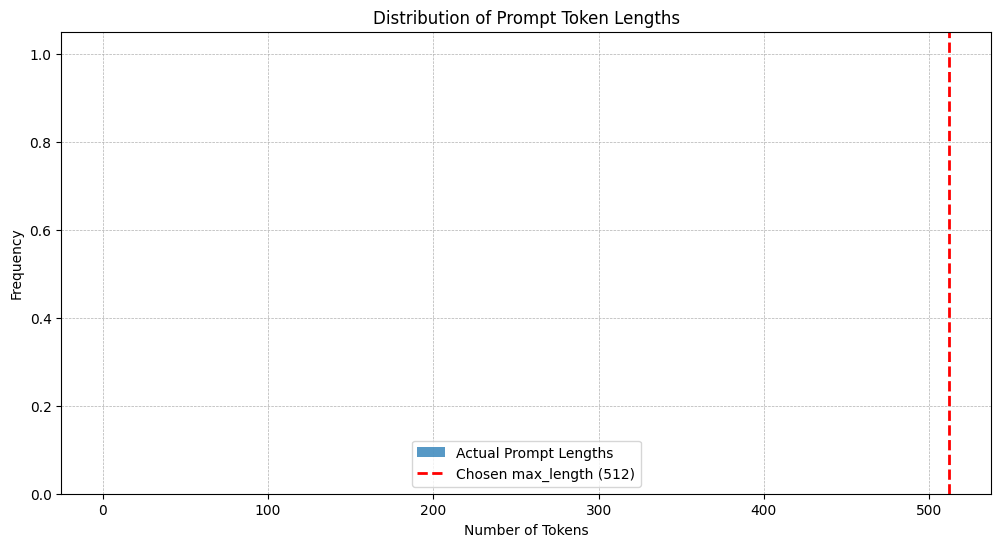

In [55]:
# # --- 4.4 Analyze Prompt Token Lengths ---
# import numpy as np
# import matplotlib.pyplot as plt

# # Tokenize the 'text' field of the training dataset to get lengths
# token_lengths = [len(tokenizer(s).input_ids) for s in formatted_dataset['train'][0]]

# # Compute and print statistics
# print(f"--- Token Length Statistics ---")
# print(f"Min length: {np.min(token_lengths)}")
# print(f"Max length: {np.max(token_lengths)}")
# print(f"Mean length: {np.mean(token_lengths):.2f}")
# print(f"Our chosen max_length in SFTConfig: {sft_config.max_length}")

# # Plot the histogram
# plt.figure(figsize=(12, 6))
# plt.hist(token_lengths, bins=50, alpha=0.75, label="Actual Prompt Lengths")
# plt.axvline(x=sft_config.max_length, color='red', linestyle='--', linewidth=2, label=f"Chosen max_length ({sft_config.max_length})")
# plt.title("Distribution of Prompt Token Lengths")
# plt.xlabel("Number of Tokens")
# plt.ylabel("Frequency")
# plt.legend()
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.show()

## 4.5. Prepare Quantized Model for Training

Before we can define our LoRA adapters, we must run a crucial utility function from the PEFT library: `prepare_model_for_kbit_training`. While loading a model in 4-bit precision is great for saving memory, the model in this state is not yet optimal for a stable training process. This function acts as a bridge, making the necessary modifications to the model to prepare it for backpropagation with QLoRA.

Specifically, it performs several key operations under the hood:

1.  **Casts Normalization Layers to `float32`**: Certain layers, particularly `LayerNorm`, are known to be numerically unstable when trained in low precision. To prevent training from failing due to exploding or vanishing gradients, this function intelligently finds these sensitive layers and casts their data type to full 32-bit precision. These layers act as stable "anchors" during the backward pass, even while the bulk of the model's weights remain in 4-bit.

2.  **Enables Gradient Checkpointing**: This is a powerful memory-saving technique. Instead of storing all intermediate activations from the forward pass (which consumes a large amount of VRAM) to compute gradients in the backward pass, it only stores a few strategic "checkpoints". During the backward pass, it re-computes the activations between these checkpoints. This is a classic trade-off: we use more compute time to drastically reduce memory consumption, often allowing us to use larger batch sizes or fine-tune models that would otherwise not fit in VRAM.

3.  **Prepares the Model for Adapter Injection**: The function also performs some necessary setup on the model's architecture to ensure it is ready to have LoRA adapters seamlessly injected in the next step.

In [63]:
# --- 4.5 Prepare Quantized Model for Training ---
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

## 4.6. Configure LoRA Adapters

Now we address the "LoRA" part of QLoRA. **Low-Rank Adaptation (LoRA)** is a technique where we freeze all the weights of the large pre-trained model and inject a pair of small, trainable "adapter" matrices into specific layers. During training, only the weights of these tiny adapters are updated. This is the key to parameter-efficient fine-tuning.

We create a `LoraConfig` object from the `peft` library to define the behavior of these adapters. The choice of these hyperparameters controls the **capacity** and **scaling** of our fine-tuning.

-   **`r` (Rank)**: This is the most important LoRA hyperparameter (`Config.LORA_R`). It controls the size, and therefore the **expressive power**, of our LoRA adapters. A higher `r` means larger adapter matrices, more trainable parameters, and a greater capacity to learn complex changes. A lower `r` means fewer parameters, which saves memory and reduces the risk of overfitting. For a task like ours, which focuses on learning a specific output format rather than entirely new knowledge, **a small rank like 8 or 16 is an excellent and efficient starting point.**

-   **`lora_alpha`**: This acts as a scaling factor for the LoRA adaptations (`Config.LORA_ALPHA`). The LoRA update is multiplied by `alpha/r`. The prevailing heuristic is to set **`lora_alpha = 2 * r`**. This keeps the scaling factor constant, simplifying hyperparameter tuning. It effectively removes `alpha` as a free variable we need to worry about, allowing us to focus our experiments on finding the optimal rank `r`.

-   **`bias="none"`**: This setting specifies that we will not train the bias terms of the linear layers. This is a standard choice for maximizing parameter efficiency. The original LoRA authors found that fine-tuning the bias terms added thousands of parameters for a negligible performance gain. By only training the LoRA weights (`A` and `B`), we adhere strictly to the principle of training as few parameters as possible.

-   **`target_modules`**: This specifies which layers of the base model we want to attach our LoRA adapters to. Setting it to `"all-linear"` is a convenient and effective strategy that automatically targets all linear layers within the model, such as the query, key, and value projection matrices in the attention blocks.

-   **`task_type`**: We must explicitly state that our goal is Causal Language Modeling (`"CAUSAL_LM"`) so the PEFT library can correctly configure the model for a next-token prediction task.

In [64]:
# --- 4.6 Configure LoRA Adapters ---
from peft import LoraConfig

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
)

# 5. Training

## 5.1. Define the Metrics Calculation Function

Since our `SFTConfig` is set to perform evaluation, we must provide the `SFTTrainer` with a function to compute the performance metric. For our classification task, the metric is **accuracy**.

This function, `compute_metrics`, will be called at the end of each evaluation run. It receives the model's predictions (logits) and the ground-truth labels. As we've discussed, the trainer uses a `-100` label mask to ignore prompt tokens during loss calculation. Our metrics function must do the same to ensure we are only calculating accuracy on the single, final response token (`0` or `1`).

The function will:
1.  Isolate the logits and labels.
2.  For each sequence in the batch, find the index of the last non-masked token (the token we want to score).
3.  Extract the logits for that specific token.
4.  Use `argmax` on those logits to get the predicted token ID.
5.  Compare the predicted token ID with the ground-truth label ID.
6.  Return a dictionary containing the final mean accuracy.

In [65]:
# --- 5.1 Define the Metrics Calculation Function ---
import numpy as np
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    """
    Computes accuracy on the final, unmasked token of each sequence.
    """
    # The first element of p.predictions is the logits matrix
    logits = p.predictions[0]
    labels = p.label_ids

    # Find the index of the last non-masked token for each sequence.
    # A label of -100 is a masked token, so we find the last position that is not -100.
    last_token_indices = np.array([np.where(row != -100)[0][-1] for row in labels])

    # Extract the logits for the target tokens
    last_token_logits = logits[np.arange(len(last_token_indices)), last_token_indices]

    # Get the predictions by taking the argmax of the logits
    predictions = last_token_logits.argmax(axis=-1)

    # Get the ground truth labels for the same tokens
    ground_truth_labels = labels[np.arange(len(last_token_indices)), last_token_indices]

    # Calculate accuracy
    accuracy = np.mean(predictions == ground_truth_labels)

    return {"accuracy": accuracy}

### A Deeper Look: How the Trainer Computes Loss

It is essential to understand how a causal language model like Phi-4 is actually trained. The core task is always **next-token prediction**, and the `SFTTrainer` leverages this with a clever technique called **label masking**.

Let's consider a simplified training sample from our dataset:
`...<|assistant|>1`

When this full text is tokenized and fed into the model, the Transformer architecture processes all tokens in parallel. A key feature of this parallel processing is that it produces an output logit vector (a prediction) for *every single token position* in the input sequence, not just the last one.

However, we do not want the model to learn to predict the prompt itself. We only want it to learn to produce the correct response (`1` in this case). This is where the label mask comes in. The `SFTTrainer` prepares a `labels` tensor that is the same length as the input sequence and populates it as follows:

1.  For all token positions that correspond to the input prompt (everything before `<|assistant|>`), it assigns the special value `-100`.
2.  For the token positions that correspond to the desired response (`1`), it places the actual token ID of the response.

**This entire process of creating a masked label tensor is precisely what is handled for us automatically when we set `assistant_only_loss=True` in our `SFTConfig`.**

Here is a conceptual illustration of what happens internally:

| Position | Input Token         | Label Token       | Loss Computed? |
| :------- | :------------------ | :---------------- | :------------- |
| ...      | `...`               | `-100`            | No             |
| 148      | `<|assistant|>`     | `-100`            | No             |
| 149      | `\n`                | `t_("1")`         | **Yes**        |
| 150      | `1`                 | `<eos_token>`     | **Yes**        |

The PyTorch `CrossEntropyLoss` function is specifically designed to **ignore all positions where the label is -100**.

Therefore, even though the model generates predictions for the entire 150-token sequence, the loss is only calculated on the two unmasked positions. The final loss for the sample is the average of these individual loss values, and this single number is used to update the model's trainable LoRA weights.

**In summary:** The model architecture is optimized for parallel training by predicting all next-tokens at once. The `SFTTrainer`, via the `assistant_only_loss` setting, uses a `-100` mask to ensure that learning only happens on the part of the text we care about. **The `compute_metrics` function we defined previously replicates this logic** to measure accuracy correctly on the same target tokens.

## 5.2. Initialize the SFTTrainer

Now we instantiate the `SFTTrainer`. This high-level class from the `trl` library is the orchestrator for our entire fine-tuning process. It abstracts away the complexity of the training loop, handling data batching, packing, loss calculation, optimization, and evaluation.

We initialize it by passing it all the objects we have carefully prepared:

-   **`model`**: Our 4-bit quantized base model, prepared with PEFT.
-   **`args`**: The comprehensive `SFTConfig` object that contains all our training hyperparameters and settings.
-   **`train_dataset`** & **`eval_dataset`**: Our formatted datasets. The trainer will handle tokenization and packing internally.
-   **`peft_config`**: The `LoraConfig` that tells the trainer how to apply the LoRA adapters to the model.
-   **`tokenizer`**: The tokenizer that the trainer will use for its internal data processing.
-   **`compute_metrics`**: Our custom function for calculating accuracy during evaluation.

In [67]:
# --- 5.2. Initialize the SFTTrainer (Revised with Data Collator) ---
from trl import SFTTrainer, DataCollatorForLanguageModeling

# This data collator will use our 'assistant_masks' column to create the labels
# It will set labels to -100 for all tokens where the mask is 0
data_collator = DataCollatorForLanguageModeling(
    pad_token_id=tokenizer.pad_token_id,
    completion_only_loss=False # This is for a different format; our mask handles it
)

trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["validation"],
    peft_config=lora_config,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator, # Provide the custom collator
)

ImportError: cannot import name 'DataCollatorForLanguageModeling' from 'trl' (/usr/local/lib/python3.11/dist-packages/trl/__init__.py)

## 5.3. Start the Fine-Tuning Process

With the `SFTTrainer` fully initialized, we can now begin the fine-tuning process by simply calling the `.train()` method.

This single command will execute the entire training and evaluation loop according to our `SFTConfig`:
1.  It will iterate through the training data for the specified number of epochs.
2.  At each step, it will process a batch of data, perform a forward pass, and calculate the loss on the assistant's response.
3.  It will accumulate gradients and update the LoRA adapter weights.
4.  Every `eval_and_save_steps`, it will pause training, run an evaluation on the validation set, compute the accuracy using our `compute_metrics` function, and save a model checkpoint.
5.  Throughout the process, it will log the training loss and validation metrics.
6.  Finally, after all epochs are complete, it will automatically load the weights from the checkpoint that achieved the best validation accuracy during the entire run. The `trainer.model` attribute will then hold this best-performing model.

In [ ]:
# --- 5.3. Start the Fine-Tuning Process ---
trainer.train()

## 5.4. Visualize Training and Validation Loss

After the training is complete, the `Trainer` object contains a `state` attribute that holds a detailed history of the training process, including the loss and any evaluation metrics recorded at each logging step. This log history is a list of dictionaries, which we can easily parse and visualize.

Plotting the training and validation loss curves is a crucial diagnostic step. It helps us answer key questions:
-   **Did the model learn?** The training loss should consistently decrease over time.
-   **Is the model overfitting?** Overfitting occurs when the model memorizes the training data but fails to generalize to new, unseen data. A classic sign of overfitting is when the **training loss continues to decrease while the validation loss begins to increase**.
-   **Is the learning stable?** A smooth, downward-sloping curve is ideal. A very noisy or erratic curve might suggest that the learning rate is too high.

We will use `pandas` to load the log history into a DataFrame for easy manipulation and `matplotlib` to plot the curves on the same graph for direct comparison.

In [ ]:
# --- 5.4. Visualize Training and Validation Loss ---
import pandas as pd
import matplotlib.pyplot as plt

# Access the training history from the trainer state
log_history = trainer.state.log_history

# Convert the log history to a pandas DataFrame for easier manipulation
history_df = pd.DataFrame(log_history)

# Separate the training and evaluation logs
# Training logs have a 'loss' key, evaluation logs have an 'eval_loss' key
train_logs = history_df[history_df['loss'].notna()]
eval_logs = history_df[history_df['eval_loss'].notna()]

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Validation Loss', marker='o')

# Add titles and labels for clarity
plt.title("Training and Validation Loss Curves")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# 6. Final Evaluation

## 6.1. Merge LoRA Adapters and Prepare Model for Inference

The model currently in `trainer.model` is a `PeftModel`, which consists of the frozen 4-bit base model and the trainable LoRA adapters. While this is efficient for training, it's not optimal for inference.

For faster and more straightforward inference, it is best practice to merge the trained LoRA adapter weights directly into the weights of the base model. This effectively creates a new, fine-tuned model where the weights themselves have been updated. The `.merge_and_unload()` method from the PEFT library handles this for us.

This method performs the following actions:
1.  It calculates the final weight update from the LoRA `A` and `B` matrices (`B @ A * scaling`).
2.  It adds this update directly to the corresponding weights of the frozen base model. Note that this requires de-quantizing the base model weights to a higher precision (like `bfloat16`), performing the addition, and then storing the new, merged weights.
3.  It unloads the PEFT wrapper, returning a standard `AutoModelForCausalLM` object that contains the newly merged weights.

This resulting `eval_model` is a standalone, fine-tuned model that can be used for inference without needing the `peft` library or a `LoraConfig`.

In [ ]:
# --- 6.1. Merge LoRA Adapters for Inference ---

# The trainer.model is the best model from training, loaded automatically.
# Merge the LoRA adapters into the base model
eval_model = trainer.model.merge_and_unload()

print("--- LoRA adapters merged and PEFT model unloaded. ---")
print("The 'eval_model' is now a standard AutoModelForCausalLM.")

## 6.2. Evaluate on the Test Set and Save Results

We will now run the final evaluation on the test set. To enable a deeper analysis, we will not only calculate the final accuracy but also save the model's raw predictions and its confidence scores for each sample.

The loop will now perform these enhanced steps:
1.  Format the prompt for each test sample.
2.  Use `eval_model.generate()` to produce the prediction. Critically, we will add the `output_scores=True` and `return_dict_in_generate=True` arguments. This forces the model to also return the raw logits for the generated token, giving us insight into its confidence.
3.  Extract the predicted token and the ground-truth label.
4.  From the returned scores, we will extract the logits for the two tokens we care about: `'0'` and `'1'`. We will then apply a softmax function to convert these logits into probabilities.
5.  We will store the problem index, the true label, the predicted label, and the calculated probabilities in a list.
6.  Finally, we will convert this list into a pandas DataFrame and save it as a CSV file to Google Drive, including a timestamp in the filename for versioning.

In [ ]:
# --- 6.2. Evaluate on the Test Set and Save Results ---
import torch
import pandas as pd
from tqdm import tqdm
import re
import datetime

# Get token IDs for '0' and '1' to extract specific logits
label_0_token_id = tokenizer("0", add_special_tokens=False).input_ids[0]
label_1_token_id = tokenizer("1", add_special_tokens=False).input_ids[0]

# Use the test split from our raw dataset (which includes index and error type)
test_dataset = raw_dataset["test"]
eval_model.eval()

# List to store detailed results for each sample
evaluation_results = []

print(f"\n--- Evaluating model on {total_predictions} test samples ---")

for i in tqdm(range(len(test_dataset))):
    sample = test_dataset[i]
    prompt_dict = create_prompt(sample)
    prompt_text = prompt_dict['text'].split("<|assistant|>")[0] + "<|assistant|>\n"

    inputs = tokenizer(prompt_text, return_tensors="pt", return_attention_mask=False).to("cuda")

    with torch.no_grad():
        # Add output_scores and return_dict_in_generate to get the logits
        outputs = eval_model.generate(
            **inputs,
            max_new_tokens=5,
            eos_token_id=tokenizer.eos_token_id,
            output_scores=True,
            return_dict_in_generate=True
        )

    # --- Extract Prediction ---
    generated_ids = outputs.sequences[0, inputs['input_ids'].shape[1]:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    match = re.search(r'\d', generated_text)
    prediction = int(match.group(0)) if match else -1 # Use -1 for failed parse

    # --- Extract Probabilities ---
    # The 'scores' tuple contains logits for each generated step. We want the first one.
    first_step_logits = outputs.scores[0][0] # Get logits for the first generated token
    # Apply softmax to convert logits to probabilities
    probs = torch.nn.functional.softmax(first_step_logits, dim=-1)
    prob_for_0 = probs[label_0_token_id].item()
    prob_for_1 = probs[label_1_token_id].item()

    # Store all relevant information
    evaluation_results.append({
        "index": sample.get("index", i),
        "true_label": sample['label'],
        "predicted_label": prediction,
        "prob_0": prob_for_0,
        "prob_1": prob_for_1,
        # The 'error_type' is needed for the 3x3 matrix later
        "error_type": sample.get("error_type", "unknown")
    })

# --- Save Results to Google Drive ---
results_df = pd.DataFrame(evaluation_results)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f"evaluation_results_{timestamp}.csv"
results_save_path = f"/content/drive/My Drive/{results_filename}"

results_df.to_csv(results_save_path, index=False)

print(f"\n--- Evaluation Complete ---")
print(f"Detailed results saved to: {results_save_path}")

## 6.3. Analyze Results with Confusion Matrices

With our detailed evaluation results saved, we can now perform a more nuanced analysis of the model's behavior using **confusion matrices**. A confusion matrix provides a clear visual summary of a classifier's performance, showing not just *how many* predictions were wrong, but also *what kind* of mistakes were made.

To get the ground-truth error type for each sample, we will load the `sft_level1_catalog.csv` file that was created during dataset preparation. This metadata file contains the `index` and the original `error_type` for every sample in our dataset. We will merge this information with our prediction results using the `index` as a key.

We will generate two matrices:

1.  **Binary Confusion Matrix**: A standard 2x2 matrix showing the counts for True/False Positives and Negatives.
2.  **Error Type Analysis Matrix**: To dig deeper, we will map our binary labels and the true error types from the metadata into three categories: `Correct`, `Conceptual`, and `Computational`. This will produce a 3x2 matrix that shows how our binary classifier performs on each specific error type, answering questions like, "Is the model better at detecting computational or conceptual errors?"

In [ ]:
# --- 6.3. Load Metadata and Plot Confusion Matrices ---
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# --- 1. Load and Merge Data ---

# Load the prediction results DataFrame we created in the previous cell
df_results = results_df

# Load the metadata catalog from the dataset directory
metadata_path = f"{BasicConfig.DATASET_PATH}/sft_level1_catalog.csv"
try:
    df_metadata = pd.read_csv(metadata_path)
    # Merge the metadata with our results on the 'index' column
    # We select only the 'index' and 'error_type' columns to avoid redundancy
    df_full = pd.merge(df_results, df_metadata[['index', 'error_type']], on='index', how='left')
    print("Metadata successfully loaded and merged with prediction results.")
except FileNotFoundError:
    print(f"Metadata file not found at {metadata_path}. Skipping detailed error analysis.")
    df_full = df_results # Fallback to just results if metadata is missing

# --- 2. Plot Binary (0 vs 1) Confusion Matrix ---
cm_binary = confusion_matrix(df_full['true_label'], df_full['predicted_label'], labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Correct (0)', 'Predicted Flawed (1)'],
            yticklabels=['Actual Correct (0)', 'Actual Flawed (1)'])
plt.title('Binary Confusion Matrix (Correct vs. Flawed)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print a detailed classification report for the binary task
print("\n--- Binary Classification Report ---")
print(classification_report(df_full['true_label'], df_full['predicted_label'], target_names=['Correct (0)', 'Flawed (1)']))


# --- 3. Plot 3x2 Error Type Analysis Matrix ---

# Check if the merge was successful and the 'error_type' column exists
if 'error_type' in df_full.columns:
    # Function to map the detailed error type string to our three main categories
    def get_main_category(error_str):
        if not isinstance(error_str, str):
            return 'Correct' # Handle non-string or NaN values
        error_str = error_str.lower()
        if 'correct' in error_str:
            return 'Correct'
        elif 'conceptual' in error_str:
            return 'Conceptual'
        # Treat all other error types (computational, off-by-n, etc.) as 'Computational'
        elif 'computational' in error_str:
             return 'Computational'
        # Fallback for any other string
        return 'Other Flawed'

    # Create a new column with the main ground-truth category
    df_full['true_category'] = df_full['error_type'].apply(get_main_category)

    # Create a column for the predicted category (Correct vs. Flawed)
    df_full['predicted_category'] = df_full['predicted_label'].apply(lambda x: 'Correct' if x == 0 else 'Flawed')

    # Define the order for the confusion matrix axes
    row_labels = ['Correct', 'Conceptual', 'Computational']
    col_labels = ['Correct', 'Flawed']

    # Filter out any 'Other Flawed' for a clean 3x2 matrix
    df_filtered = df_full[df_full['true_category'].isin(row_labels)]

    cm_3x2 = confusion_matrix(
        df_filtered['true_category'],
        df_filtered['predicted_category'],
        labels=row_labels
    )

    # We need to reorder the columns of the matrix to match our desired ['Correct', 'Flawed'] order
    # scikit-learn's confusion_matrix with string labels will order them alphabetically ('Correct', 'Flawed')
    # So the output is already in the correct column order.

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_3x2, annot=True, fmt='d', cmap='Greens',
                xticklabels=col_labels,
                yticklabels=row_labels)
    plt.title('Error Type Analysis: Model Predictions per True Error Category')
    plt.ylabel('Actual Error Category')
    plt.xlabel('Predicted Class')
    plt.show()

else:
    print("\n'error_type' column not found in merged data. Skipping error type analysis matrix.")

## 6.4. Qualitative Analysis: Reviewing Model Predictions

Quantitative metrics like accuracy and confusion matrices provide a high-level overview of performance. However, to truly understand the model's strengths and weaknesses, it is essential to perform a qualitative analysis by examining its predictions on individual examples.

This is especially useful for understanding *why* the model failed. By looking at the specific problems and solutions where its prediction was incorrect, we can identify patterns and gain insights that can guide future improvements to our dataset and training strategy.

Below, we will display a few examples from our test set, highlighting cases where the model's prediction did not match the ground-truth label.

In [ ]:
# --- 6.4. Qualitative Analysis: Reviewing Model Predictions ---

# Merge the raw text back into our results for easy display
df_for_review = pd.merge(df_full, raw_dataset['test'], on='index', how='left')

# Find incorrect predictions
incorrect_predictions_df = df_for_review[df_for_review['true_label_x'] != df_for_review['predicted_label']]

print(f"Total incorrect predictions: {len(incorrect_predictions_df)}")

# Display up to 5 examples of incorrect predictions
num_to_show = min(5, len(incorrect_predictions_df))

print(f"\n--- Displaying {num_to_show} Incorrect Predictions for Review ---")
for i, row in incorrect_predictions_df.head(num_to_show).iterrows():
    print("\n" + "="*80)
    print(f"Problem Index: {row['index']}")
    print(f"True Label: {row['true_label_x']} ({row['true_category']})")
    print(f"Predicted Label: {row['predicted_label']}")
    print(f"Model's Confidence (Prob for '1'): {row['prob_1']:.2%}")
    print("-"*80)
    print("Problem:")
    print(row['question'])
    print("\nSolution:")
    print(row['solution'])
    print("="*80)

# 7. Save Model to Hugging Face Hub

## 7.1. Push Final Adapter to Hub

As a final step, we will upload our trained LoRA adapter to the Hugging Face Hub. This is the best practice for saving, versioning, and sharing your model. Pushing to the Hub allows you to easily load the fine-tuned model for inference later without needing to re-run this entire notebook.

We will use the `push_to_hub` method, which is available on our `trainer` object. It will upload the adapter configuration and weights from the best checkpoint.

In [ ]:
# --- 7.1. Push Final Adapter to Hub ---
from huggingface_hub import notebook_login

# Log in to your Hugging Face account
notebook_login()

# Define a name for your model repository on the Hub
hub_model_name = "solution-verifier-level1-phi4-mini"

# Push the final adapter (from the best checkpoint) to the Hub
trainer.push_to_hub(hub_model_name)
print(f"Adapter pushed to Hub at: https://huggingface.co/YourUsername/{hub_model_name}")
# Note: Replace 'YourUsername' with your actual Hugging Face username.